In [1]:

import os
print("Current working directory:", os.getcwd())
import importlib

import sys
sys.path.append('/')
print(os.listdir('/data'))
print(os.getcwd())
from torchdiffeq import odeint
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#from model.init import model
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from model.Multiagent import MultiAgentFusion
# GNNs (Graph Neural Network) 
from model.mlp import MLPModel
# MAMBA 
import torch
torch.cuda.empty_cache()
import torch.nn as nn
#from model.mamba import Mamba
# LSTM 
#from model.lstm import LSTM
# GRU 
from sklearn.preprocessing import StandardScaler
from model.gru import GRUModel
# Neural Network 
#from model.neural import NeuralODE
# Transformer 
#from model.transformer import Transformer
from torch.utils.checkpoint import checkpoint
import numpy as np
import shap
from mamba_ssm import Mamba
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print(torch.__version__)  # 查看torch当前版本号
print(torch.version.cuda)  # 编译当前版本的torch使用的cuda版本号
print(torch.cuda.is_available())  # 查看当前cuda是否可用于当前版本的Torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint

Current working directory: /root/data
['gzh']
/root/data


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0+cu117
11.7
True


In [2]:
# 定义一个 Dataset 子类，负责加载数据
class LargeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [3]:
class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(d_model=hidden_size, num_encoder_layers=6, nhead=4)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)  # 输入特征进行嵌入
        x = x.unsqueeze(0)  # 加一个 batch 维度
        x = self.transformer(x, x)  # Transformer 进行处理
        x = x.squeeze(0)  # 移除 batch 维度
        x = self.fc(x)  # 输出预测
        return x

In [4]:
data = pd.read_csv('./TrafficLabelling/end.csv').values
le = LabelEncoder()
le.fit(data[:,-1])

data[:,-1]= le.transform(data[:,-1])
num_classes = len(np.unique(data[:,-1]))


In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        #print(f"Input shape before unsqueeze: {input_seq.shape}")  # Debug: Check input shape
        if len(input_seq.shape) == 2:
            input_seq = input_seq.unsqueeze(1)
            #print(f"Input shape after unsqueeze: {input_seq.shape}")  # Debug: Should now be 3D

        lstm_out, _ = self.lstm(input_seq)
        #print(f"LSTM output shape: {lstm_out.shape}")  # Debug: [batch_size, seq_len, hidden_layer_size]
        lstm_out_last = lstm_out[:, -1, :]
        predictions = self.linear(lstm_out_last)
        return predictions

In [6]:
class MambaPredictor(nn.Module):
    def __init__(self, input_dim, seq_len, n_classes, d_model=16, d_state=32, d_conv=4, expand=2):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.mamba = Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # 添加时间维度，变为 (B, 1, D)
        x = self.input_embedding(x)
        x = checkpoint(self.mamba, x)  # 使用 checkpoint 包裹 Mamba 模块
        x = x[:, -1, :]  # 使用最后一个时间步
        x = self.fc(x)
        return x


cuda


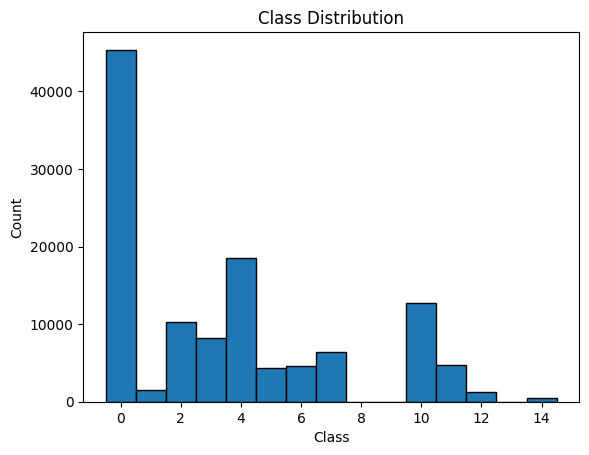

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.astype(np.float64) 
data[np.isinf(data)] = 0
X = data[:,:-1]
y = data[:,-1]

# 平衡数据集：减少类别 0, 2, 4, 10 的样本数
for class_label in [0, 2, 4, 10]:
    class_indices = np.where(y == class_label)[0]  # 找到当前类的索引
    other_classes_indices = np.where(y != class_label)[0]  # 找到其他类的索引
    
    # 随机选取当前类的一部分样本
    if class_label == 0:
        reduced_class_indices = np.random.choice(class_indices, size=len(class_indices) // 40, replace=False)
    if class_label == 2:
        reduced_class_indices = np.random.choice(class_indices, size=len(class_indices) // 10, replace=False)
    if class_label == 4:
        reduced_class_indices = np.random.choice(class_indices, size=len(class_indices) // 10, replace=False)
    if class_label == 10:
        reduced_class_indices = np.random.choice(class_indices, size=len(class_indices) // 10, replace=False)
    # 合并减少后的当前类样本与其他类样本
    balanced_indices = np.concatenate([reduced_class_indices, other_classes_indices])
    
    # 重新调整数据
    X = X[balanced_indices]
    y = y[balanced_indices]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dimension = X_train.shape[1]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16,shuffle=False)
num_classes = len(np.unique(y_train))
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
# 平衡数据集：减少类别 0, 2, 4, 10 的样本数

plt.hist(y_train, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()



In [8]:

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # 定义一个简单的全连接网络作为ODE的右侧函数
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x  # 返回logits


    def solve(self, x0, t):
        # odeint通过自动微分求解ODE
        solution = odeint(self, x0, t)
        return solution[-1]  # 取最后时刻的输出


In [9]:
class Agent:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.reward = 0.0  
        self.device = device
        self.weight = 1.0  
     
    def train_NeuralODE(self, inputs, target):
        inputs = inputs.to(self.device)
        target = target.to(self.device)
        self.model.to(self.device) 
        t = torch.linspace(0, 1, steps=100).to(self.device)
        outputs = self.model(t, inputs)  # Ensure both are on the same device

        # Compute loss
        if target.dtype != torch.long:
            target = target.long()

        loss = self.loss_fn(outputs, target)
        return loss

    def train(self, inputs, target):
        inputs = inputs.to(self.device)
        self.model.to(self.device) 
        # 确保数据在正确设备上
        inputs, target = inputs.to(self.device), target.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        if target.dtype != torch.long:
            target = target.long()
        loss = self.loss_fn(outputs, target)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    def predict_NeuralODE(self, X):
        # 获取当前设备
        device = next(self.model.parameters()).device  # 获取模型参数所在设备

        t = torch.linspace(0, 1, steps=10, device=device)  # 假设时间点 t 需要在相同设备上

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32, device=device)  # 将 X 移动到同一个设备

        outputs = self.model(t, X)  # 模型前向传播
        
        return outputs.detach().cpu().numpy()  # 返回 CPU 上的 numpy 数组

    def predict(self, X):
        device = next(self.model.parameters()).device  # 获取模型参数所在的设备

        if isinstance(X, torch.Tensor):  # 如果 X 已经是 tensor 类型
            X = X.to(device)  # 将 X 移动到模型所在的设备
        else:
            X = torch.tensor(X, dtype=torch.float32).to(device)
        outputs = self.model(X)  # 模型前向传播
        return outputs.detach().cpu().numpy()  # 返回 CPU 上的 numpy 数组

    def update_reward(self, reward):
        self.reward += reward

    def adjust_learning_rate(self, min_lr=0.001, max_lr=0.01):
        for param_group in self.optimizer.param_groups:
            new_lr = max(min_lr, min(max_lr, param_group['lr'] + self.reward * 0.001))
            param_group['lr'] = new_lr

    def adjust_weight(self):
        self.weight = max(0.1, self.reward)  # 确保最小权重为0.1

    @staticmethod
    def normalize_weights(agents):
        total_reward = sum(agent.reward for agent in agents)
        if total_reward > 0:
            for agent in agents:
                agent.weight = agent.reward / total_reward
        else:
            for agent in agents:
                agent.weight = 1.0 / len(agents)  # 如果没有奖励，均分权重


In [10]:
print(num_classes)

15


In [11]:

#model = MultiAgentFusion(input_size=5, hidden_size=64, output_size=num_classes)
mlp_model = MLPModel(input_size=dimension, hidden_size=2, output_size=num_classes)
gru_model = GRUModel(input_size=dimension, hidden_layer_size=2, num_layers=2, output_size=num_classes)
lstm_model = LSTM(input_size=dimension, hidden_layer_size=2, num_layers=2, output_size=num_classes)
batch, length, dim = 2, 64, 768
mamba_model = MambaPredictor(input_dim=dimension, seq_len=1, n_classes=num_classes)
neural_model = NeuralODE(input_dim=dimension, hidden_dim=1, output_dim=num_classes)
#transformer_model = Transformer(input_size=dimension, hidden_size=4, num_classes=num_classes)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  

In [12]:
# 定义保存模型的函数
def save_model(agent, agent_id, epoch, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)  # 创建保存目录
    model_filename = f"agent_{agent_id}_epoch_{epoch}.pth"
    model_path = os.path.join(save_dir, model_filename)
    
    # 保存模型的state_dict
    torch.save(agent.model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

In [13]:

device = 'cuda'
# 创建每个代理时传入设备
agents = [
    
    Agent(
        model=neural_model,
        optimizer=optim.Adam(neural_model.parameters(), lr=0.1),
        loss_fn=nn.CrossEntropyLoss(),
        device='cpu'
    ),
    Agent(
        model=lstm_model,
        optimizer=optim.Adam(lstm_model.parameters(), lr=0.1),
        loss_fn=nn.CrossEntropyLoss(),
        device='cpu'
    ),
    Agent(
        model=mlp_model,
        optimizer=optim.Adam(mlp_model.parameters(), lr=0.1),
        loss_fn=nn.CrossEntropyLoss(),
        device='cpu'
    ),
    Agent(
        model=gru_model,
        optimizer=optim.Adam(gru_model.parameters(), lr=0.1),
        loss_fn=nn.CrossEntropyLoss(),
        device='cpu'
    ),
  
    Agent(
        model=mamba_model,
        optimizer=optim.Adam(mamba_model.parameters(), lr=0.1),
        loss_fn=nn.CrossEntropyLoss(),
        device='cuda'
    ),
]

# Main loop for training, fusion, feedback, and optimization

train_losses = []
val_losses = []
accuracy_scores = []
agent_outputs = []


In [14]:
def shap_predict_wrapper(agent, X):
    # 确保输入是正确的
    X = torch.tensor(X, dtype=torch.float32).to(device)
    return agent.model(X).detach().cpu().numpy()  # 返回的是一个 numpy 数组
num_epochs=100

In [15]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # 记录loss
    agent_outputs = []
    for batch_idx, (data, target) in enumerate(train_loader):
        print(train_loader)
        losses = []
        for i, agent in enumerate(agents):
            if i==0:
                print(f"Training Agent {i + 1}")
                agent_loss = []
                #print(data)
                #print(target)
                with torch.cuda.amp.autocast():  # 使用混合精度
                    loss = agent.train_NeuralODE(data, target)
                agent_loss.append(loss)  # 将每个batch的loss存入列表
                print(f"Batch {batch_idx}, Loss: {loss}")
                
                losses.append(np.mean([l.cpu().detach().numpy() for l in agent_loss]))  # 记录当前agent每个epoch的loss平均值
                agent_outputs.append(agent.predict_NeuralODE(X_test))
                # 每个epoch结束后保存模型
                #save_model(agent, i, 1)    
            else:
                print(f"Training Agent {i + 1}")
                agent_loss = []
                #print(f"Batch {batch_idx}, Data: {data}")  # 打印数据结构
            
                with torch.cuda.amp.autocast():  # 使用混合精度
                    loss = agent.train(data, target)
                agent_loss.append(loss)  # 将每个batch的loss存入列表
                print(f"Batch {batch_idx}, Loss: {loss}")
                # 将当前agent的所有loss加入到全局loss记录中
                losses.append(np.mean(agent_loss))  # 记录当前agent每个epoch的loss平均值
                # Generate predictions for FB distribution
                agent_outputs.append(agent.predict(X_test))
                # 每个epoch结束后保存模型
                #save_model(agent, i, 1)     
 
    fb_distribution = torch.mean(torch.stack(agent_outputs), dim=0)

    for i, agent in enumerate(agents):
        if i >= len(agent_outputs):  # 防止越界访问
            print(f"Warning: agent_outputs does not have an output for agent {i + 1}")
            continue  # 跳过当前 agent
        # 确保 agent_outputs 和 fb_distribution 是 Torch 张量并且需要梯度
        raw_output = torch.tensor(agent_outputs[i], dtype=torch.float32, requires_grad=True)  # 使 raw_output 具有梯度
        fb_distribution_tensor = fb_distribution  # 此时 fb_distribution 已经是 Torch 张量，继续使用
        # 使用损失函数计算损失
        fb_loss = agent.loss_fn(raw_output, fb_distribution_tensor)
        # 反向传播
        agent.optimizer.zero_grad()
        fb_loss.backward()  # 现在可以正常计算梯度
        agent.optimizer.step()
    # Shapley value calculation
    shapley_values = []
    for i, agent in enumerate(agents):
        # Randomly sample from X_train for Shapley calculation
        if(i==0):
            sample_idx = np.random.choice(len(X_train), size=100, replace=False)
            X_sample = X_train[sample_idx]
            explainer = shap.KernelExplainer(agent.predict_NeuralODE, X_sample)
            shap_values = explainer.shap_values(X_test)
            shapley_values.append(np.mean(shap_values))
        else:
            sample_idx = np.random.choice(len(X_train), size=100, replace=False)
            X_sample = X_train[sample_idx]
            explainer = shap.KernelExplainer(agent.predict, X_sample)
            shap_values = explainer.shap_values(X_test)
            shapley_values.append(np.mean(shap_values))
    # Reward and learning rate adjustment
    total_shapley = sum(shapley_values)
    for i, agent in enumerate(agents):
        reward = shapley_values[i] / total_shapley if total_shapley > 0 else 0
        agent.update_reward(reward)
        agent.adjust_weight()
        agent.adjust_learning_rate()

    # Display rewards
    for i, agent in enumerate(agents):
        print(f"Agent {i + 1} reward after iteration {epoch + 1}: {agent.reward}")
    # epoch结束
    print(f"Epoch {epoch+1} completed.")

Epoch 1/100


Training Agent 1
Batch 0, Loss: 3.0128660202026367
Training Agent 2
Batch 0, Loss: 2.5996286869049072
Training Agent 3
Batch 0, Loss: 16497.56640625
Training Agent 4
Batch 0, Loss: 3.0238425731658936
Training Agent 5
Batch 0, Loss: 2.7474365234375
Training Agent 1
Batch 1, Loss: 2.854903221130371
Training Agent 2
Batch 1, Loss: 2.563863515853882
Training Agent 3
Batch 1, Loss: 2.721766948699951
Training Agent 4
Batch 1, Loss: 2.7251136302948
Training Agent 5
Batch 1, Loss: 2.6834716796875
Training Agent 1
Batch 2, Loss: 2.8059911727905273
Training Agent 2
Batch 2, Loss: 2.6441259384155273
Training Agent 3
Batch 2, Loss: 2.64510178565979
Training Agent 4
Batch 2, Loss: 2.627420425415039
Training Agent 5
Batch 2, Loss: 5.542157173156738
Training Agent 1
Batch 3, Loss: 2.5871505737304688
Training Agent 2
Batch 3, Loss: 2.4706335067749023
Training Agent 3
Batch 3, Loss: 2.6059274673461914
Training Agent 4
Batch 3, Loss: 2.470240354537964
Training Agent 5
Batch 3, Loss: 6.263885498046875
Tr

KeyboardInterrupt: 

In [ ]:

#将模型进行封装
class MultiAgentModel:
    def __init__(self, agents, device='cuda'):
        """
        封装多个代理模型
        :param agents: 一个包含 Agent 实例的列表
        :param device: 设备类型
        """
        self.agents = agents
        self.device = device
        self.agent_weights = [1.0 / len(agents)] * len(agents)  # 初始均分权重

    def train(self, train_loader, X_test, num_epochs=10):
        """
        训练模型并基于 Shapley 值调整代理权重
        :param train_loader: 训练数据加载器
        :param X_test: 用于 Shapley 计算的测试数据
        :param num_epochs: 训练轮数
        """
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            
            # 每个代理独立训练
            for batch_idx, (data, target) in enumerate(train_loader):
                losses = []
                for i, agent in enumerate(self.agents):
                    if isinstance(agent.model, NeuralODE):
                        loss = agent.train_NeuralODE(data, target)
                    else:
                        loss = agent.train(data, target)
                    losses.append(loss)

            # 计算 Shapley 值
            shapley_values = self._calculate_shapley(X_test)
            
            # 根据 Shapley 值调整权重
            total_shapley = sum(shapley_values)
            if total_shapley > 0:
                self.agent_weights = [val / total_shapley for val in shapley_values]
            else:
                self.agent_weights = [1.0 / len(self.agents)] * len(self.agents)

    def predict(self, X):
        """
        预测结果，整合多个代理的预测值
        :param X: 输入数据
        :return: 整体预测结果
        """
        final_output = None
        for agent, weight in zip(self.agents, self.agent_weights):
            if isinstance(agent.model, NeuralODE):
                output = agent.predict_NeuralODE(X)
            else:
                output = agent.predict(X)
            
            weighted_output = weight * output  # 加权整合
            if final_output is None:
                final_output = weighted_output
            else:
                final_output += weighted_output
        
        return final_output

    def _calculate_shapley(self, X_test):
        """
        计算 Shapley 值，用于衡量各代理的贡献
        :param X_test: 测试数据
        :return: 各代理的 Shapley 值
        """
        shapley_values = []
        for i, agent in enumerate(self.agents):
            if isinstance(agent.model, NeuralODE):
                explainer = shap.KernelExplainer(agent.predict_NeuralODE, X_test)
            else:
                explainer = shap.KernelExplainer(agent.predict, X_test)
            shap_values = explainer.shap_values(X_test)
            shapley_values.append(np.mean(shap_values))
        
        return shapley_values

In [ ]:
plt.figure(figsize=(10, 6))
for agent_name, losses in loss_curves.items():
    plt.plot(range(1, num_iterations + 1), losses, label=agent_name)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve for Each Agent')
plt.legend()
plt.grid()
plt.show()

In [ ]:
nvcc --version  